# Unsupervised Segmentation for Sentinel-2 Satellite Imagery

Michael Mommert, Stuttgart University of Applied Sciences, 2024

This Notebook introduces unsupervised segmentation as a task. We will apply segmentation to a set of 5 Sentinel-2 satellite images (extracted from the [BigEarthNet dataset](https://bigearth.net/)). We will implement and test different segmentation methods to identify image areas with (hopefully) similar semantic meaning. 

Keep in mind that we treat segmentation as an unsupervised method here: there are no class labels involved. We will introduce supervised classification (also on segmented images as we produce here) in a pixel-wise classification tutorial.

In [ ]:
%pip install numpy \
    matplotlib \
    scikit-learn \
    scikit-image \
    seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

## Data Download

We will download a small sample dataset containing Sentinel-2 satellite imagery and unpack the dataset:

In [3]:
# download dataset
!wget https://zenodo.org/records/12819787/files/sentinel2_coastal_scenes.zip?download=1 -O sentinel2.zip

import zipfile

# extract dataset zipfile
with zipfile.ZipFile('sentinel2.zip', 'r') as zip_ref:
    zip_ref.extractall('./')


--2024-10-31 14:37:01--  https://zenodo.org/records/12819787/files/sentinel2_coastal_scenes.zip?download=1
Resolving zenodo.org (zenodo.org)... 2001:1458:d00:3a::100:33a, 2001:1458:d00:9::100:195, 2001:1458:d00:3b::100:200, ...
Connecting to zenodo.org (zenodo.org)|2001:1458:d00:3a::100:33a|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 963332 (941K) [application/octet-stream]
Saving to: ‘sentinel2.zip’

sentinel2.zip       100%[===================>] 940,75K  2,69MB/s    in 0,3s    

2024-10-31 14:37:01 (2,69 MB/s) - ‘sentinel2.zip’ saved [963332/963332]



We read in all images from the dataset into a single NumPy array:

In [4]:
data = []
for filename in os.listdir('data/'):
    if filename.endswith('.npy'):
        data.append(np.load(open(os.path.join('data', filename), 'rb'), allow_pickle=True))
data = np.array(data)

The `data` array is built up in such a way that it contains 5 images, 12 bands per image and each image has a height of 120 pixels and a width of 120 pixels. This dimensionality is reflected by the shape of the array:

In [5]:
data.shape

(5, 12, 120, 120)

**Exercise**: Experiment with the data array and extract the following information:

* all bands of the second image;
* the green band (index 2) of the third image;
* RGB bands (indices 3, 2 and 1) for each image.


In [6]:
# use this cell for the exercise

Let's visualize one of the images. We will introduce a variable `i` that refers to the image index (possible values: 0, 1, 2, 3, 4):

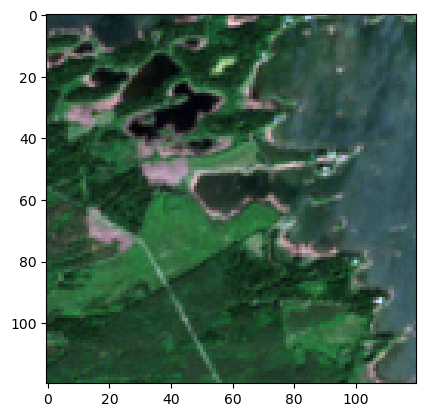

In [7]:
i = 0  # image id

# first, we extract the R, G and B bands and stack them into the shape [120, 120, 3]
img = np.dstack([data[i][3], data[i][2], data[i][1]])

# then we normalize the pixel values in such a way that they range from 0 (min) to 1 (max)
img = (img-np.min(img, axis=(0,1)))/(np.max(img, axis=(0,1)) - np.min(img, axis=(0,1)))

# now we can plot the image
plt.imshow(img)

**Exercise**: Familiarize yourself with the different images in the dataset by changing `i` in the previous code cell. What land cover types do you see?

## Segmentation with RGB data

We start segmentation on RGB-only data. For that purpose, we extract a `data_rgb` array that only contains the RGB bands (in the order B, G and R; the order is not important for the segmentation process):

In [8]:
data_rgb = data[:, 1:4, :, :]
data_rgb.shape

(5, 3, 120, 120)

Our method of choice for segmentation is a clustering method, $k$-Means. This method gets as input a list of samples and it will find *clusters* or overdensities, i.e., areas in this sample space where many samples can be found. 

In this application, each sample is represented by a pixel from our input image (or images). Using only the RGB image data, each sample is represented by a 3d vector. Clusters therefore represent sets of pixels with similar spectral properties. Hence, we can use this technique as a means to perform image segmentation. 

We apply k-Means clustering to segment our RGB dataset. We have to set the number of clusters ($k$) that we would like to identify. We will start with two clusters:

In [9]:
from sklearn.cluster import KMeans

k = 2 # number of clusters

model = KMeans(n_clusters=k)  # instantiate the method, which we call our "model"

# we "fit" the model to the first image; this means that it finds clusters based on the pixels in that image
model.fit(np.dstack(data_rgb[0]).reshape(-1, data_rgb.shape[1]))
# note that we have to linearize the image: every pixel (rows) is represented by 12 bands (columns)

/home/mommermi/software/anaconda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2)

Now that the model is fit, we can "predict" the cluster assignment for every pixel in a given image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


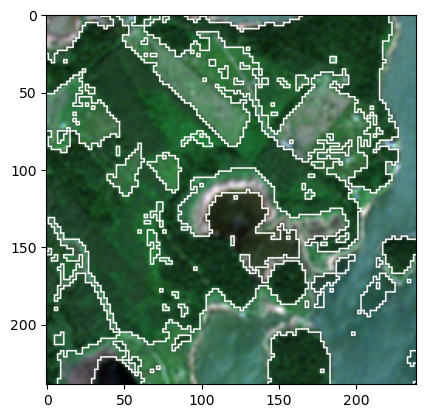

In [10]:
from skimage.segmentation import mark_boundaries

i = 3  # image id

# this is the prediction step that assigns every pixel a cluster id
pred = model.predict(np.dstack(data_rgb[i]).reshape(-1, data_rgb.shape[1])).reshape(data_rgb[i].shape[1:])
# Note that we have to linearize the input data again, and we have to reshape the output in the original image shape 

img = np.dstack([data[i][3], data[i][2], data[i][1]])  # extract RGB
img = (img-np.min(img, axis=(0,1)))/(np.max(img, axis=(0,1)) - np.min(img, axis=(0,1)))  # normalize

# plot the image with an overlay indicating the different segments
plt.imshow(mark_boundaries(img, pred, color=(255, 255, 255), mode='subpixel'))

**Exercise**: Describe the segmentation output. Are the output segments large or small? How do you think we can improve the segmentation result?

## Segmentation with multispectral data

We repeat the same k-Means segmentation ($k=2$) with multispectral data (all 12 bands instead of 3): 

/home/mommermi/software/anaconda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


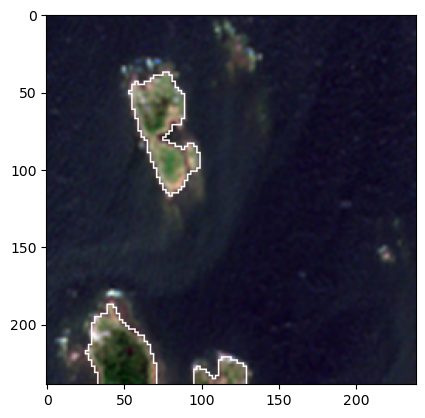

In [11]:
from skimage.segmentation import mark_boundaries

i = 2  # image id

# we "fit" our model to the first image
model = KMeans(n_clusters=k)
model.fit(np.dstack(data[0]).reshape(-1, data.shape[1]))

# we predict results for image i
pred = model.predict(np.dstack(data[i]).reshape(-1, data.shape[1])).reshape(data[i].shape[1:])

# we plot the results 
img = np.dstack([data[i][3], data[i][2], data[i][1]])
img = (img-np.min(img, axis=(0,1)))/(np.max(img, axis=(0,1)) - np.min(img, axis=(0,1)))
plt.imshow(mark_boundaries(img, pred, color=(255, 255, 255), mode='subpixel'))

**Exercise**: Are the predictions derived by this model better or worse?

**Exercise**: Identify the band or bands that are necessary for a robust identification of surface waters. (Hint: copy code cell above and play with the band combinations that go into the clustering)

In [12]:
# use this cell for the exercise

## More data...

So far, we have only applied segmentation to individual images. Now we will apply the clustering to our entire dataset (using all available bands and all available images). Let's see how the results will vary...

/home/mommermi/software/anaconda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


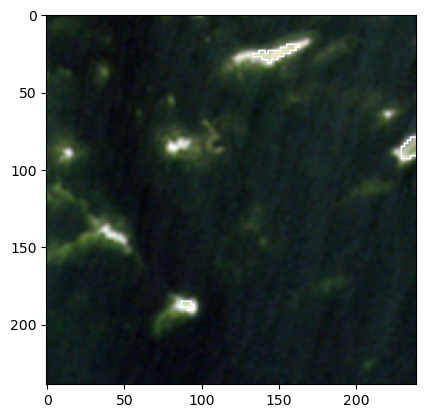

In [13]:
i = 4  # image id
k = 2  # number of clusters

# fit model to all images and all bands
model = KMeans(n_clusters=k)
model.fit(np.stack(np.dstack(data)).reshape(-1, 12))

# predict cluster affiliation for image i
pred = model.predict(np.dstack(data[i]).reshape(-1, 12)).reshape(data[i].shape[1:])
 
# plot results
img = np.dstack([data[i][3], data[i][2], data[i][1]])
img = (img-np.min(img, axis=(0,1)))/(np.max(img, axis=(0,1)) - np.min(img, axis=(0,1)))
plt.imshow(mark_boundaries(img, pred, color=(255, 255, 255), mode='subpixel'))


**Exercise**: What do you observe? Did the segmentation results improve?

## More clusters...

So far, we have only considered two clusters. But we are not limited to two clusters. Let's increase the number of clusters to 5:

/home/mommermi/software/anaconda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


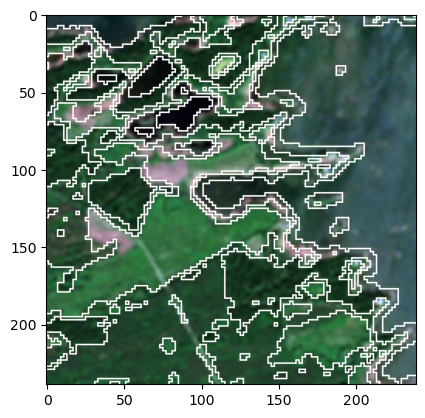

In [14]:
i = 0  # image id
k = 5  # number of clusters

# fit model to all images and all bands
model = KMeans(n_clusters=k)
model.fit(np.stack(np.dstack(data)).reshape(-1, 12))

# predict cluster affiliation for image i
pred = model.predict(np.dstack(data[i]).reshape(-1, 12)).reshape(data[i].shape[1:])
 
# plot results
img = np.dstack([data[i][3], data[i][2], data[i][1]])
img = (img-np.min(img, axis=(0,1)))/(np.max(img, axis=(0,1)) - np.min(img, axis=(0,1)))
plt.imshow(mark_boundaries(img, pred, color=(255, 255, 255), mode='subpixel'))

The result looks crowded. Let's have a look at the individual clusters that were found.

/home/mommermi/software/anaconda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


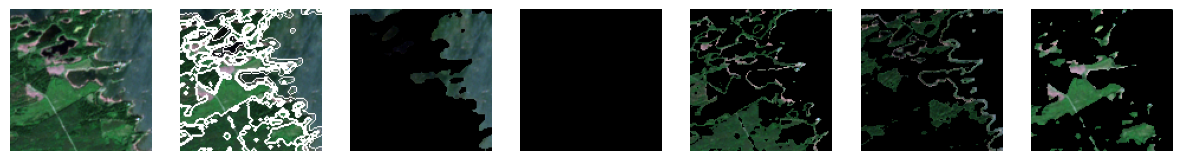

In [15]:
k = 5  # number of clusters
i = 0   # image id

# extract RGB data for plotting
img = np.dstack([data[i][3], data[i][2], data[i][1]])
img = (img-np.min(img, axis=(0,1)))/(np.max(img, axis=(0,1)) - np.min(img, axis=(0,1)))

# fit model to all images and all bands
model = KMeans(n_clusters=k)
model.fit(np.dstack(data).reshape(-1, 12))

# predict cluster affiliation for image i
pred = model.predict(np.dstack(data[i]).reshape(-1, 12)).reshape(data[i].shape[1:])

# create plot
f, ax = plt.subplots(1, k+2, sharex=True, sharey=True, figsize=(15, 3))
ax = ax.flatten()

# plot the image 
ax[0].imshow(img)
ax[0].axis('off')

# plot the image with boundaries
ax[1].imshow(mark_boundaries(img, pred, color=(255, 255, 255)))
ax[1].axis('off')

# plot the individual clusters
for i in range(k):
    tmp_img = img.copy()  # create a copy of img
    tmp_img[pred != i] = (0, 0, 0)  # set those pixels to zero that are not part of cluster i
    ax[i+2].imshow(tmp_img)  # plot this cluster
    ax[i+2].axis('off')

**Exercise**: explore the impact of the number of classes on the segmentation results. Which number of clusters works best? What pseudo-labels would you assign to the different classes?

## SLIC Segmentation

We will now use a different segmentation method. SLIC, or Simple Linear Iterative Clustering, builds on the $k$-Means algorithm to perform clustering. However, instead of only considering the pixel values in the different bands, it performs clustering on a 5-dimensional input: a tranformation of RGB colors and the two pixel coordinates. 

SLIC results in *superpixels*, contiguous pixel areas with similar spectral properties. The goal is that all pixels in the same superpixel have similar spectral properties and that all superpixels are approximately of the same size. The idea is that these superpixels can be used as input for a subsequent supervised classification.

Let's generate some superpixels: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


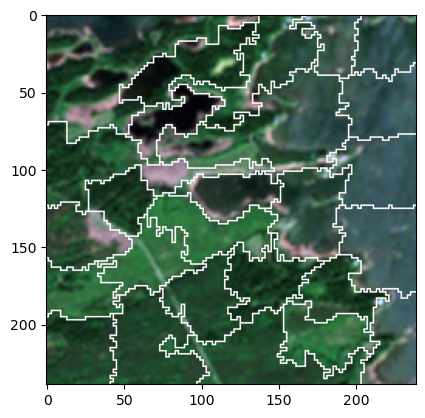

In [16]:
from skimage.segmentation import slic

i = 0 # image id

# apply SLIC to (RGB-only data of) image i; the n_segments parameter controls the approximate number of superpixels to be defines
pred_slic = slic(np.dstack(data_rgb[i]), n_segments=40, start_label=0)

# extract and normalize RGB data for plotting 
img = np.dstack([data[i][3], data[i][2], data[i][1]])
img = (img-np.min(img, axis=(0,1)))/(np.max(img, axis=(0,1)) - np.min(img, axis=(0,1)))

# plot results
plt.imshow(mark_boundaries(img, pred_slic, color=(255, 255, 255), mode='subpixel'))

**Exercise**: play with the parameters of the SLIC method. What settings derive superpixels that look promising for a subsequent classification process based on land-use/land-cover classes?

In [17]:
# use this cell for the exercise